In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tải các thư viện cần thiết:

In [ ]:
#Thư viện xử lí hình ảnh và train
import cv2
import os
import glob
import matplotlib.pyplot as plt
import random
import numpy as np

#CNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Add, Activation,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#MobilenNetv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

#ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

#KNN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


Đường dẫn đến thư mục data

In [ ]:
dataset_path = '/content/drive/MyDrive/TraiCay'

Danh sách các loại trái cây trong thư mục

In [ ]:
categories = ['cachua', 'cam', 'chuoi', 'duahau', 'le', 'nho', 'quyt', 'tao','thom', 'xoai']

Duyệt qua các ảnh và lưu dữ liệu và nhãn

In [ ]:
data = []
labels = []

# Đọc và xử lý từng ảnh trong các thư mục loại trái cây
for category in categories:
    path = os.path.join(dataset_path, category)
    for img_path in glob.glob(path + '/*.jpg'):  # thay đổi đuôi nếu ảnh không phải .jpg
        image = cv2.imread(img_path)
        image = cv2.resize(image, (64, 64))  # điều chỉnh kích thước ảnh nếu cần
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # chuyển sang RGB cho dễ xử lý

        data.append(image)
        labels.append(category)

print(f"Đã tải {len(data)} ảnh với {len(set(labels))} loại trái cây.")

Đã tải 2269 ảnh với 10 loại trái cây.


Kiểm tra dữ liệu

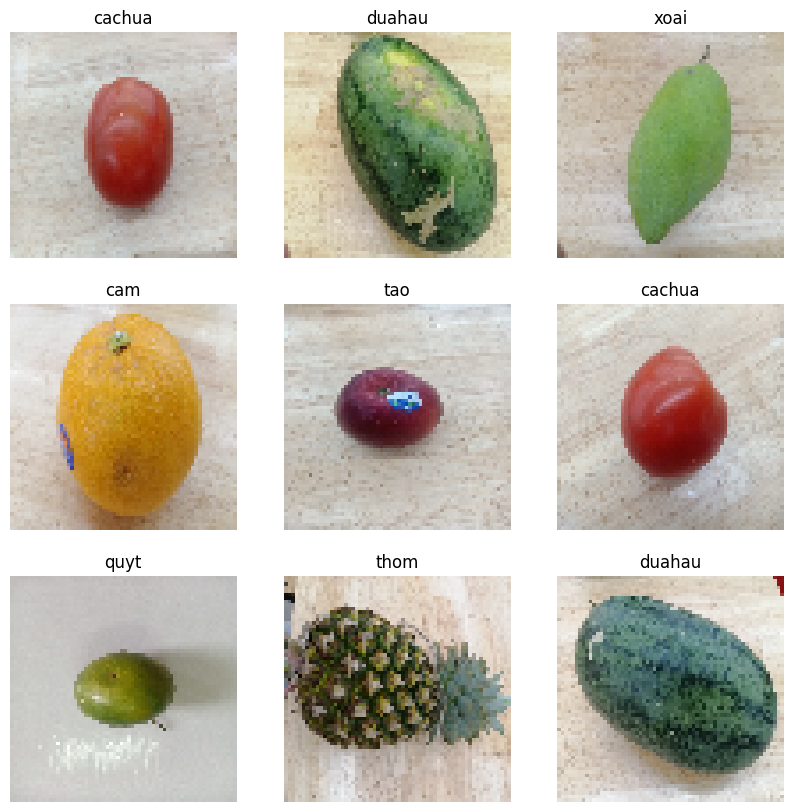

In [ ]:
# Hiển thị một vài ảnh mẫu từ dữ liệu
plt.figure(figsize=(10, 10))
for i in range(9):
    index = random.randint(0, len(data) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[index])
    plt.title(labels[index])
    plt.axis('off')
plt.show()

Chuyển đổi và chuẩn hóa dữ liệu

In [ ]:
# Chuyển đổi dữ liệu và nhãn thành numpy arrays
data = np.array(data, dtype="float32") / 255.0  # Chuẩn hóa ảnh thành giá trị từ 0-1
labels = np.array(labels)

# Mã hóa nhãn thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)  # Chuyển nhãn sang dạng one-hot encoding

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Dữ liệu huấn luyện: {X_train.shape}, Dữ liệu kiểm tra: {X_test.shape}")

Dữ liệu huấn luyện: (1815, 64, 64, 3), Dữ liệu kiểm tra: (454, 64, 64, 3)


***Xây dựng mô hình CNN để phân loại trái cây***



In [ ]:
# Xây dựng kiến trúc mô hình
model = Sequential([
    #Tầng tích chập
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),# chuẩn hóa đầu ra của tầng tích chập
    MaxPooling2D(pool_size=(2, 2)),# giảm kích thước không gian của đặc trưng (feature map) bằng cách lấy giá trị lớn nhất trong vùng kích thước (2, 2)

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    #Tầng làm phẳng
    Flatten(),#chuyển đổi thành 1D
    Dense(512, activation='relu'),
    Dropout(0.5),#ngắt ngẫu nhiên 50% để tránh overfitting
    Dense(len(categories), activation='softmax')  # số lớp đầu ra bằng số loại trái cây
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Data augmentation giúp tăng cường dữ liệu đầu vào, giúp cải thiện hiệu suất mô hình

In [ ]:


# Cấu hình data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,#xoay ảnh
    width_shift_range=0.2,#dịch chuyển ngang
    height_shift_range=0.2,#dịch chuyển dọc
    shear_range=0.2,#cắt xén
    zoom_range=0.2,#phóng to
    horizontal_flip=True,#lật ảnh ngang ngẫu nhiên
    fill_mode="nearest"#bù đắp pixel
)

# Huấn luyện mô hình với data augmentation
batch_size = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step - accuracy: 0.6261 - loss: 1.5408 - val_accuracy: 0.0947 - val_loss: 4.0549
Epoch 2/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.9375 - loss: 0.3061

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9375 - loss: 0.3061 - val_accuracy: 0.0947 - val_loss: 4.1613
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 570ms/step - accuracy: 0.8607 - loss: 0.4967 - val_accuracy: 0.2070 - val_loss: 4.9003
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9062 - loss: 0.3897 - val_accuracy: 0.2026 - val_loss: 4.8482
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.8847 - loss: 0.3456 - val_accuracy: 0.0925 - val_loss: 9.4069
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.1338 - val_accuracy: 0.0925 - val_loss: 9.0483
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - accuracy: 0.9150 - loss: 0.2489 - val_accuracy: 0.0925 - val_loss: 8.6659
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8125 - loss: 1.4286 - val_accuracy: 0.0925 - val_loss: 8.8608
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.9056 - loss: 0.3732 - val_accuracy: 0.0969 - val_

**Huấn luyện mô hình và Đánh giá mô hình**

Dự đoán thử mô hình

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


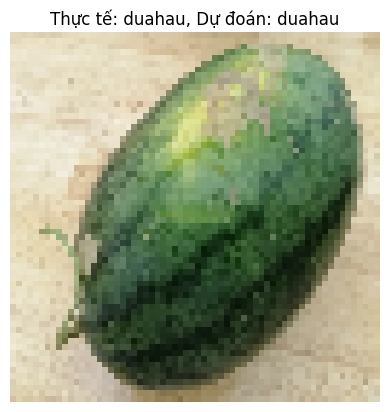

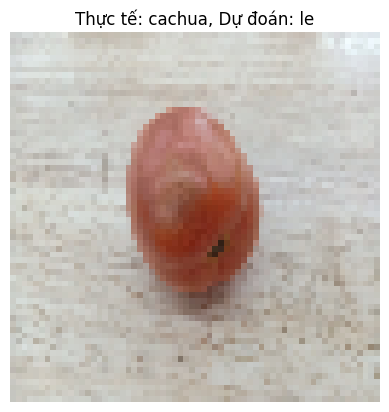

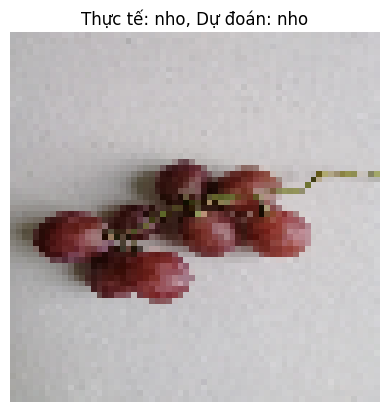

In [ ]:
# Lấy ngẫu nhiên 3 ảnh trong tập kiểm tra
idx = random.sample(range(len(X_test)), 3)
sample_images = np.array([X_test[i] for i in idx])  # Batch ảnh
sample_labels = np.array([y_test[i] for i in idx])  # Batch nhãn thực tế

# Mở rộng chiều cuối để phù hợp với định dạng input của mô hình
sample_images_expanded = np.expand_dims(sample_images, axis=-1)

# Dự đoán
predictions = model.predict(sample_images_expanded)

# Hiển thị từng ảnh với kết quả dự đoán và nhãn thực tế
for i in range(len(sample_images)):
    predicted_label = le.inverse_transform([np.argmax(predictions[i])])[0]
    true_label = le.inverse_transform([np.argmax(sample_labels[i])])[0]

    # Hiển thị ảnh
    plt.imshow(sample_images[i], cmap='gray')  # Điều chỉnh nếu ảnh không grayscale
    plt.title(f"Thực tế: {true_label}, Dự đoán: {predicted_label}")
    plt.axis('off')
    plt.show()

Đánh giá mô hình CNN (sử dụng MobileNetV2 chuyển các đặc trưng hữu ích và chạy MATRIX trên KNN)

<ipython-input-11-bda4e79daf5d>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
Accuracy: 98.02%
Độ mất mát (Loss): 0.0198
Classification Report:
              precision    recall  f1-score   support

      cachua       0.95      1.00      0.97        52
         cam       1.00      1.00      1.00        60
       chuoi       0.50      0.67      0.57         3
      duahau       1.00      1.00      1.00        55
          le       0.98      0.98      0.98        43
         nho       0.96      1.00      0.98        55
        quyt       1.00      1.00      1.00        52
         tao       0.97      0.93      0.95        40
        thom       1.00      0.96      0.98        52
        xoai       1.00      0.95      0.98        42

    accuracy                           0.98       454
   macro avg       0.94      0.95      0.94       454
weighted avg       0.98      0.98      0.98       454



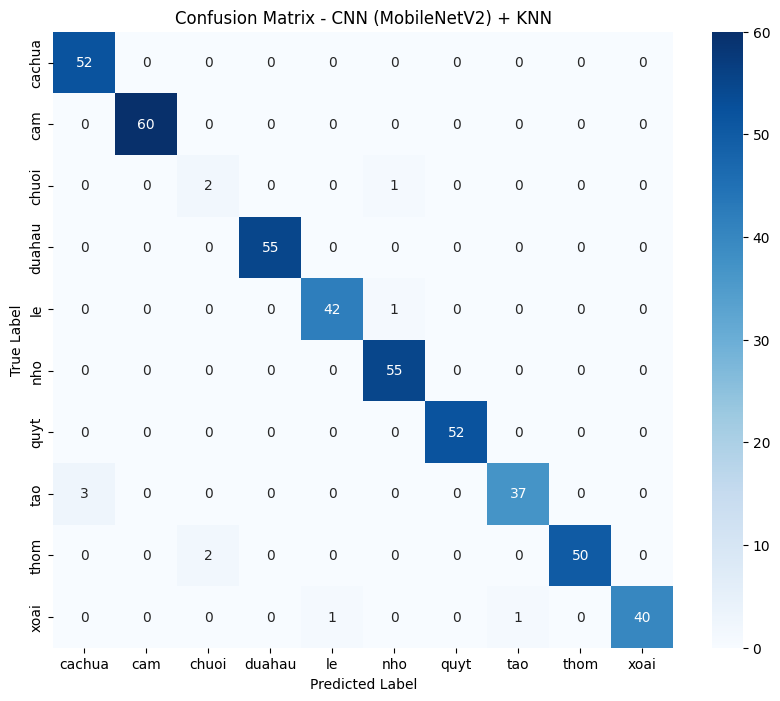

In [ ]:
# Tải MobileNetV2 với trọng số ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Trích xuất đặc trưng từ MobileNetV2 cho tập huấn luyện và kiểm tra
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)

# Chuyển đổi đặc trưng thành dạng phẳng
flat_train_features = train_features.reshape(len(X_train), -1)
flat_test_features = test_features.reshape(len(X_test), -1)

# Giảm chiều với PCA
pca = PCA(n_components=100)
pca_train_data = pca.fit_transform(flat_train_features)
pca_test_data = pca.transform(flat_test_features)

# Khởi tạo và huấn luyện mô hình KNN
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(pca_train_data, y_train.argmax(axis=1))

# Dự đoán trên tập kiểm tra
knn_predictions = knn_model.predict(pca_test_data)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test.argmax(axis=1), knn_predictions)
loss = 1 - accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Độ mất mát (Loss): {loss:.4f}")

# Báo cáo chi tiết
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), knn_predictions, target_names=categories))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), knn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN (MobileNetV2) + KNN")
plt.show()

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Độ chính xác trên tập kiểm tra: {test_acc * 100:.2f}%")
print(f"Mất mát trên tập kiểm tra: {test_loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9109 - loss: 0.4688
Độ chính xác trên tập kiểm tra: 89.65%
Mất mát trên tập kiểm tra: 0.4930


**Biểu đồ độ chính xác và độ mất mát qua các epoch**

Biểu đồ độ chính xác

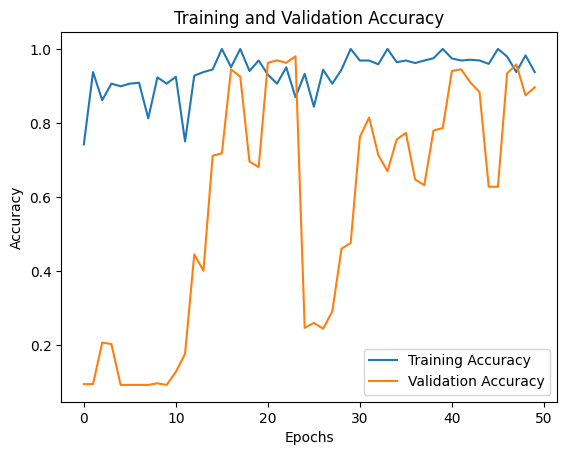

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

Biểu đồ độ mất mát

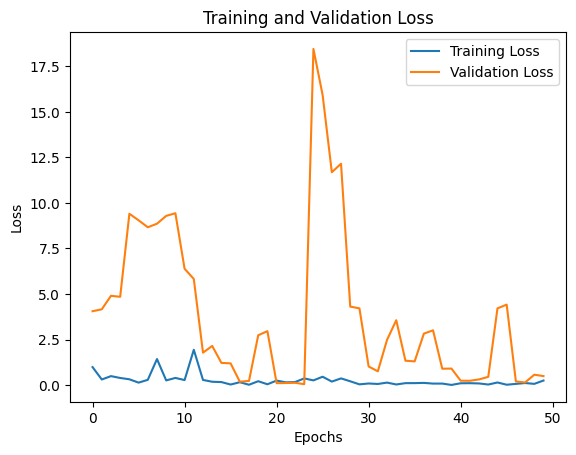

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Mô hình MobileNetV2***

Đóng băng các lớp của base_model

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Thêm các lớp cuối để phù hợp với số loại trái cây


In [ ]:
x = base_model.output
x = Flatten()(x)#Tách thành vector 1 chiều
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)#loại ngẫu nhiên
output = Dense(len(categories), activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Biên dịch mô hình
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 32, 32, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 32, 32, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 32, 32, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 32, 32, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 32, 32, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 32, 32, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 32, 32, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 32, 32, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 32, 32, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 33, 33, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 16, 16, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,914,762 (11.12 MB)

 Trainable params: 656,778 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Huấn luyện MobileNetV2

In [ ]:
history_mobilenet = model_mobilenet.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.6126 - loss: 1.5354 - val_accuracy: 0.9427 - val_loss: 0.1860
Epoch 2/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7812 - loss: 0.4402

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7812 - loss: 0.4402 - val_accuracy: 0.9427 - val_loss: 0.2012
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.8702 - loss: 0.4021 - val_accuracy: 0.9471 - val_loss: 0.1523
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8125 - loss: 0.5022 - val_accuracy: 0.9449 - val_loss: 0.1523
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.9131 - loss: 0.2357 - val_accuracy: 0.9736 - val_loss: 0.0903
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9062 - loss: 0.1329 - val_accuracy: 0.9736 - val_loss: 0.0913
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9203 - loss: 0.2390 - val_accuracy: 0.9626 - val_loss: 0.0979
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8750 - loss: 0.2489 - val_accuracy: 0.9559 - val_loss: 0.1103
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.9100 - loss: 0.2115 - val_accuracy: 0.9780 - val_

Dự đoán Mô hình

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


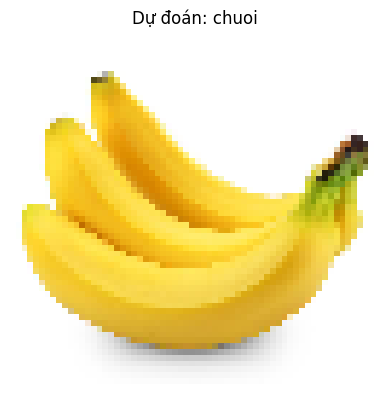

In [ ]:
def predict_image(img, model, categories):
    # Resize ảnh về kích thước (64, 64)
    img_resized = cv2.resize(img, (64, 64))
    # Chuyển ảnh từ BGR sang RGB và chuẩn hóa về phạm vi [0, 1]
    img_normalized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) / 255.0
    # Thêm chiều batch để phù hợp với input của mô hình
    img_input = np.expand_dims(img_normalized, axis=0)

    # Dự đoán với mô hình
    prediction = model.predict(img_input)
    # Lấy chỉ số của lớp có xác suất cao nhất
    predicted_class = np.argmax(prediction, axis=1)[0]
    # Lấy tên loại trái cây dựa trên chỉ số
    predicted_label = categories[predicted_class]

    return predicted_label, img_normalized

# Đường dẫn đến ảnh bạn muốn dự đoán
test_image_path = '/content/drive/MyDrive/TraiCay/chuoi/banana.jpg'
test_img = cv2.imread(test_image_path)

# Dự đoán và lấy nhãn, ảnh chuẩn hóa
predicted_label, img_to_show = predict_image(test_img, model_mobilenet, categories)

# Hiển thị ảnh với nhãn dự đoán
plt.imshow(img_to_show)
plt.title(f"Dự đoán: {predicted_label}")
plt.axis('off')
plt.show()

Đánh giá MobileNetV2

In [ ]:
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(X_test, y_test)
print(f"Mô hình MobileNetV2 - Độ chính xác trên tập kiểm tra: {test_acc_mobilenet * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9723 - loss: 0.0972
Mô hình MobileNetV2 - Độ chính xác trên tập kiểm tra: 97.36%


In [ ]:
print(f"Mô hình MobileNetV2 - Độ mất mát trên tập kiểm tra: {test_loss_mobilenet:.4f}")

Mô hình MobileNetV2 - Độ mất mát trên tập kiểm tra: 0.0728


<ipython-input-21-ed5580855da0>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Accuracy: 98.46%
Độ mất mát (Loss): 0.0154
Classification Report:
              precision    recall  f1-score   support

      cachua       0.95      1.00      0.97        52
         cam       1.00      1.00      1.00        60
       chuoi       0.67      0.67      0.67         3
      duahau       1.00      1.00      1.00        55
          le       0.98      0.98      0.98        43
         nho       0.96      1.00      0.98        55
        quyt       1.00      1.00      1.00        52
         tao       1.00      0.93      0.96        40
        thom       1.00      0.98      0.99        52
        xoai       1.00      0.98      0.99        42

    accuracy                           0.98       454
   macro avg       0.96      0.95      0.95       454
weighted avg       0.99      0.98      0.98       454



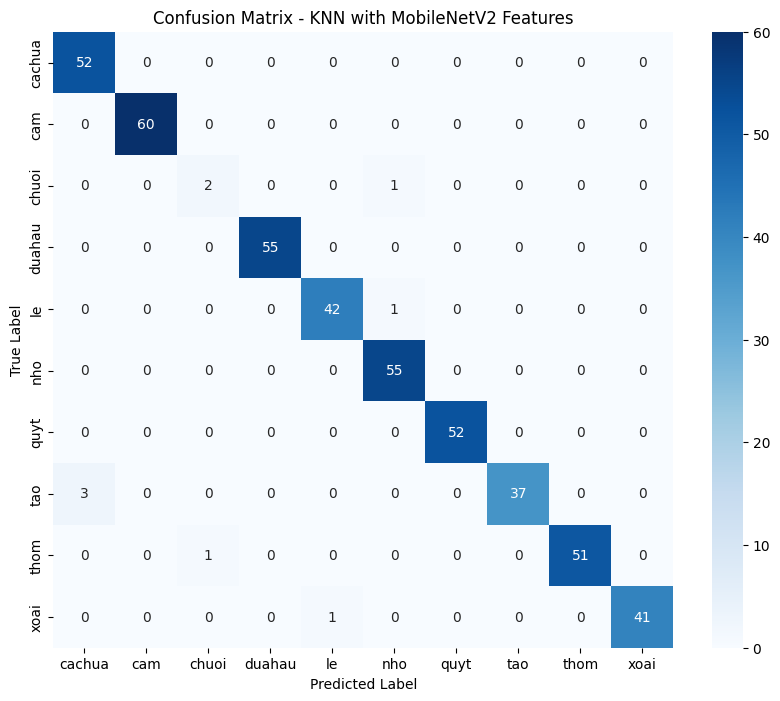

In [ ]:
# Tải MobileNetV2 với trọng số ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Trích xuất đặc trưng từ MobileNetV2 cho tập huấn luyện và kiểm tra
train_features = base_model.predict(X_train)
test_features = base_model.predict(X_test)

# Chuyển đổi đặc trưng thành dạng phẳng
flat_train_features = train_features.reshape(len(X_train), -1)
flat_test_features = test_features.reshape(len(X_test), -1)

# Giảm chiều với PCA (tùy chọn, nhưng thường được khuyến nghị)
pca = PCA(n_components=100)  # Sử dụng 100 thành phần chính
pca_train_data = pca.fit_transform(flat_train_features)#giảm số chiều dữ liệu để giảm độ phức tạp, giảm nhiễu và tăng tốc độ tính toán.
pca_test_data = pca.transform(flat_test_features)

# Khởi tạo và huấn luyện mô hình KNN
k = 5  # Chọn số lượng hàng xóm K
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(pca_train_data, y_train.argmax(axis=1))

# Dự đoán trên tập kiểm tra
knn_predictions = knn_model.predict(pca_test_data)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test.argmax(axis=1), knn_predictions)
loss = 1 - accuracy  # Mất mát = 1 - độ chính xác
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Độ mất mát (Loss): {loss:.4f}")

# Báo cáo chi tiết
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), knn_predictions, target_names=categories))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), knn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - KNN with MobileNetV2 Features")
plt.show()

Biểu đồ đánh giá độ chính xác và mất mát


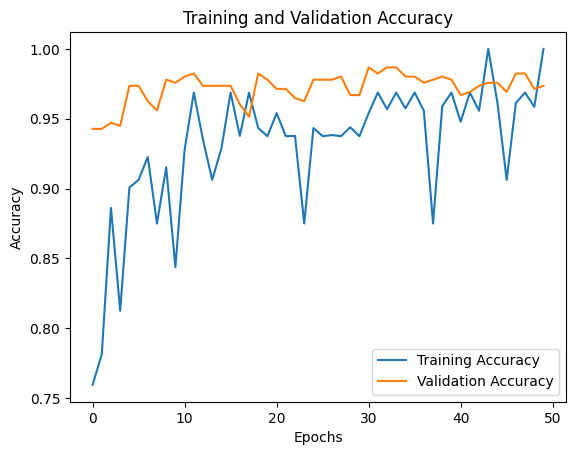

In [ ]:
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

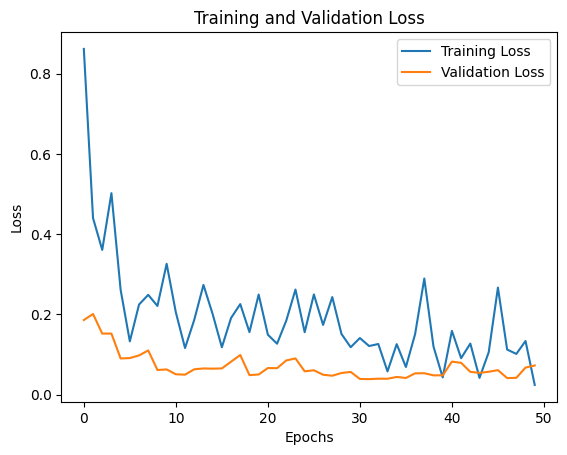

In [ ]:
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Mô Hình ResNet50***

Load mô hình ResNet50 với các trọng số được huấn luyện trước trên ImageNet

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Thêm các lớp Fully Connected cho bài toán

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):#đầu vào cộng trực tiếp đầu ra
    # Lưu lại đầu vào ban đầu để dùng trong phép cộng
    shortcut = x

    # Lớp tích chập đầu tiên
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)#nếu tride = 1
    x = BatchNormalization()(x)#chuẩn hóa đầu ra
    x = Activation('relu')(x)

    # Lớp tích chập thứ hai
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Nếu cần thiết, thay đổi kích thước của shortcut để phù hợp với output
    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)#kernel để thay đổi số kênh
        shortcut = BatchNormalization()(shortcut)

    # Cộng shortcut và đầu ra của lớp tích chập rồi áp dụng hàm kích hoạt ReLU
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


Huấn luyên Retnes50


In [ ]:
# Khởi tạo đầu vào
input_layer = Input(shape=(64, 64, 3))

# Thêm các lớp Conv2D và Residual Block
x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=2)(x)

# Thêm các Residual Blocks
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)  # Giảm kích thước với stride=2
x = residual_block(x, 128)

# Global Average Pooling và lớp Fully Connected cuối cùng
x = GlobalAveragePooling2D()(x)#Tính trung bình toàn bộ không gian trên mỗi kênh
output_layer = Dense(len(categories), activation='softmax')(x)

# Tạo mô hình
model_resnet_custom = Model(inputs=input_layer, outputs=output_layer)

# Biên dịch mô hình
model_resnet_custom.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history_resnet_custom = model_resnet_custom.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6846 - loss: 0.9921 - val_accuracy: 0.0881 - val_loss: 6.9189
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9265 - loss: 0.2237 - val_accuracy: 0.0881 - val_loss: 8.5858
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9524 - loss: 0.1522 - val_accuracy: 0.1366 - val_loss: 7.4041
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9609 - loss: 0.1220 - val_accuracy: 0.1123 - val_loss: 14.7508
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9743 - loss: 0.0848 - val_accuracy: 0.1035 - val_loss: 14.2544
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9825 - loss: 0.0503 - val_accuracy: 0.1630 - val_loss: 7.5053
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9874 - loss: 0.0374 - val_accuracy: 0.5066 - val_loss: 4.1284
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9850 - loss: 0.0497 - val_accuracy: 0.3877 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


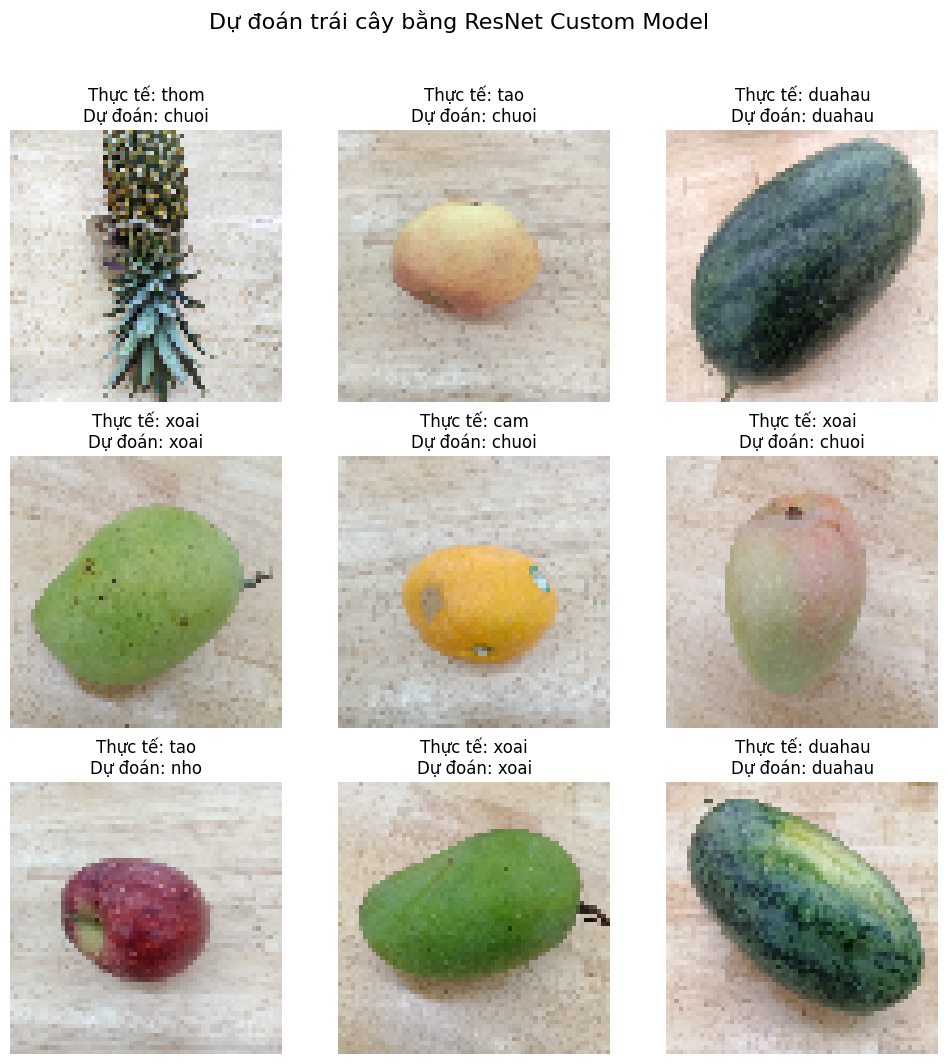

In [ ]:
# Chọn ngẫu nhiên 9 ảnh từ tập kiểm tra để hiển thị
num_images = 9
indices = np.random.choice(range(len(X_test)), num_images, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # Lấy ảnh từ tập kiểm tra
    image = X_test[idx]
    true_label = categories[y_test[idx].argmax()]  # Nhãn thực tế

    # Dự đoán nhãn của ảnh
    pred_label_idx = model_resnet_custom.predict(image.reshape(1, 64, 64, 3)).argmax()
    pred_label = categories[pred_label_idx]

    # Hiển thị ảnh với nhãn dự đoán và nhãn thực tế
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Thực tế: {true_label}\nDự đoán: {pred_label}")
    plt.axis('off')

plt.suptitle("Dự đoán trái cây bằng ResNet Custom Model", fontsize=16)
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 568ms/step - accuracy: 0.6371 - loss: 3.6366
Mô hình ResNet50 - Độ chính xác trên tập kiểm tra: 63.66%
Độ mất mát (Loss): 3.6060
Classification Report:
              precision    recall  f1-score   support

      cachua       0.85      0.63      0.73        52
         cam       1.00      0.55      0.71        60
       chuoi       0.02      1.00      0.04         3
      duahau       1.00      0.96      0.98        55
          le       0.00      0.00      0.00        43
         nho       0.71      1.00      0.83        55
        quyt       0.86      0.60      0.70        52
         tao       0.00      0.00      0.00        40
        thom       1.00      0.92      0.96        52
        xoai       0.92      0.79      0.85        42

    accuracy                           0.64       454
   macro avg       0.64      0.65      0.58       454
weighted avg       0.73      0.64      0.67       454



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


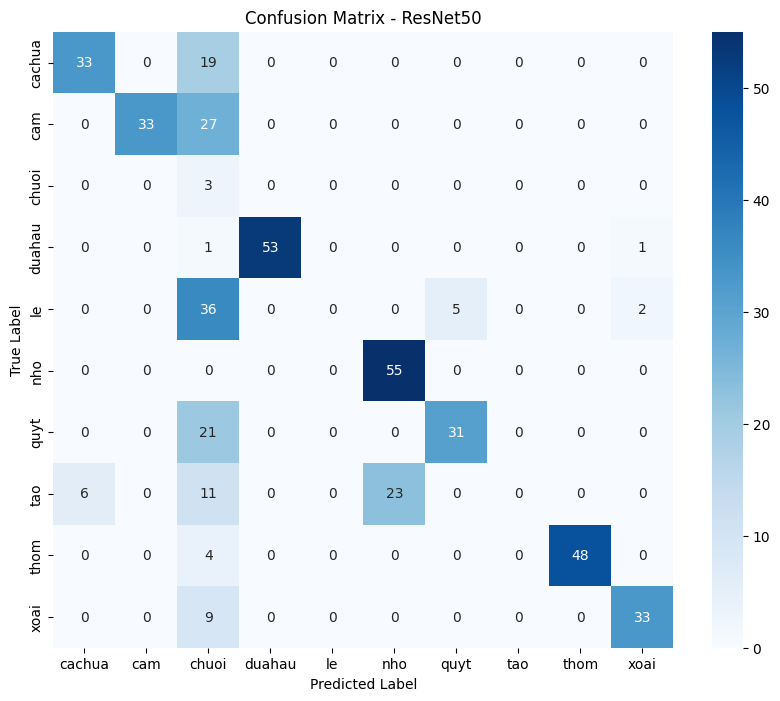

In [ ]:
y_pred = model_resnet_custom.predict(X_test) # Dự đoán xác suất của từng lớp cho các mẫu trong tập kiểm tra.
y_pred_classes = np.argmax(y_pred, axis=1)#mảng các nhãn dự đoán (các số nguyên),Tìm chỉ số của lớp có xác suất cao nhất cho từng mẫu.
y_true_classes = np.argmax(y_test, axis=1)#mảng các nhãn thực tế.
test_loss_resnet, test_acc_resnet = model_resnet_custom.evaluate(X_test, y_test)
print(f"Mô hình ResNet50 - Độ chính xác trên tập kiểm tra: {test_acc_resnet * 100:.2f}%")
print(f"Độ mất mát (Loss): {test_loss_resnet:.4f}") # Changed 'loss' to 'test_loss_resnet'
# Báo cáo chi tiết
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50")
plt.show()

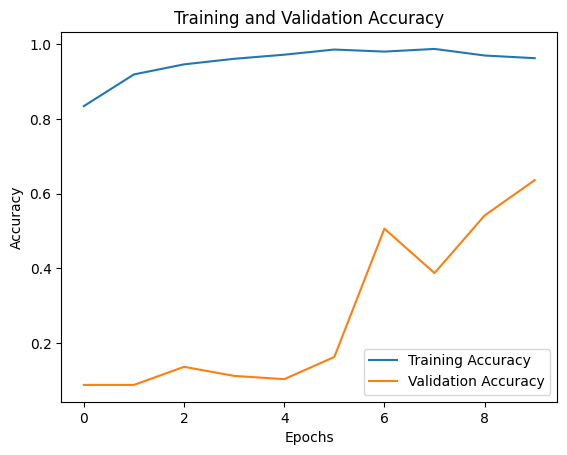

In [ ]:
plt.plot(history_resnet_custom.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_custom.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

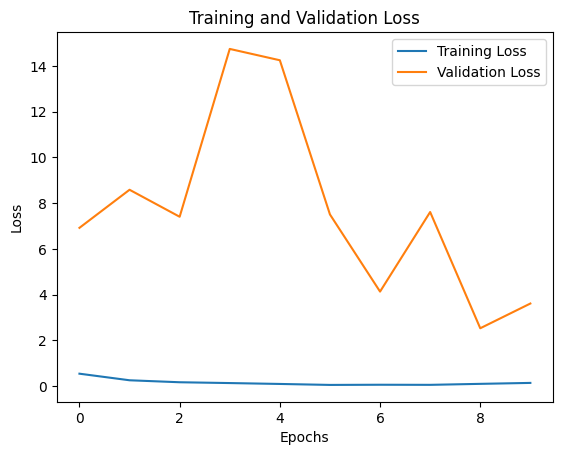

In [ ]:
plt.plot(history_resnet_custom.history['loss'], label='Training Loss')
plt.plot(history_resnet_custom.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(f"Mô hình ResNet50 - Độ mất mát trên tập kiểm tra: {test_loss_resnet:.4f}")

Mô hình ResNet50 - Độ mất mát trên tập kiểm tra: 3.6060


***Mô hình KNN***

Accuracy: 90.53%
Độ mất mát (Loss): 0.0947
Classification Report:
              precision    recall  f1-score   support

      cachua       0.94      0.90      0.92        52
         cam       0.98      1.00      0.99        60
       chuoi       1.00      0.67      0.80         3
      duahau       0.93      0.93      0.93        55
          le       0.75      0.95      0.84        43
         nho       0.95      0.67      0.79        55
        quyt       0.91      1.00      0.95        52
         tao       0.90      0.95      0.93        40
        thom       0.89      0.81      0.85        52
        xoai       0.89      0.98      0.93        42

    accuracy                           0.91       454
   macro avg       0.91      0.89      0.89       454
weighted avg       0.91      0.91      0.90       454



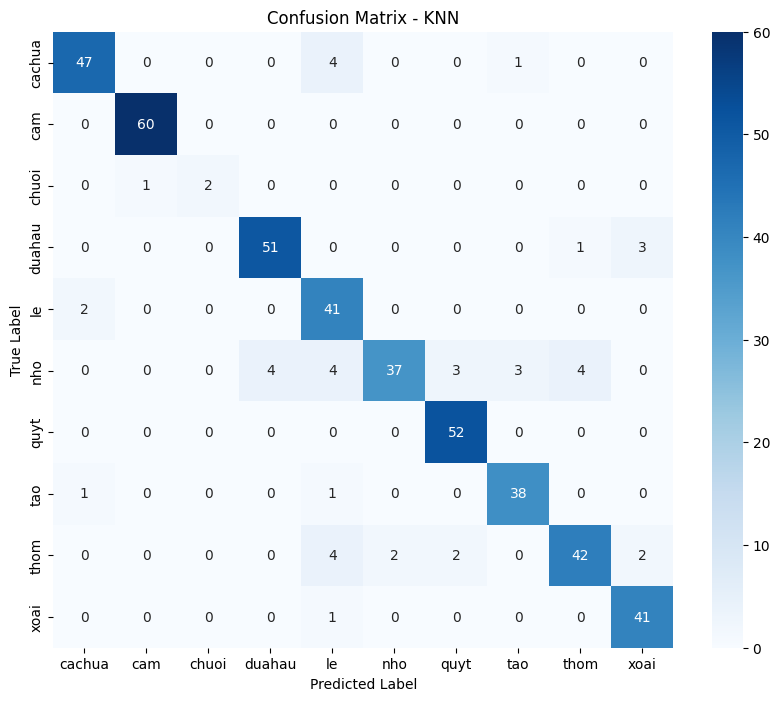

In [ ]:
# Chuyển đổi dữ liệu huấn luyện và kiểm tra thành dạng phẳng
flat_train_data = X_train.reshape(len(X_train), -1)
flat_test_data = X_test.reshape(len(X_test), -1)

# Giảm chiều với PCA để tăng hiệu quả tính toán
pca = PCA(n_components=100)  # Sử dụng 100 thành phần chính
pca_train_data = pca.fit_transform(flat_train_data)
pca_test_data = pca.transform(flat_test_data)

# Khởi tạo và huấn luyện mô hình KNN
k = 5  # Chọn số lượng hàng xóm K (có thể thử nghiệm với các giá trị khác)
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(pca_train_data, y_train.argmax(axis=1))

# Dự đoán trên tập kiểm tra
knn_predictions = knn_model.predict(pca_test_data)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test.argmax(axis=1), knn_predictions)
loss = 1 - accuracy  # Mất mát = 1 - độ chính xác
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Độ mất mát (Loss): {loss:.4f}")


# Báo cáo chi tiết
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), knn_predictions, target_names=categories))

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test.argmax(axis=1), knn_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - KNN")
plt.show()

Biểu đồ mất mát và chính xác

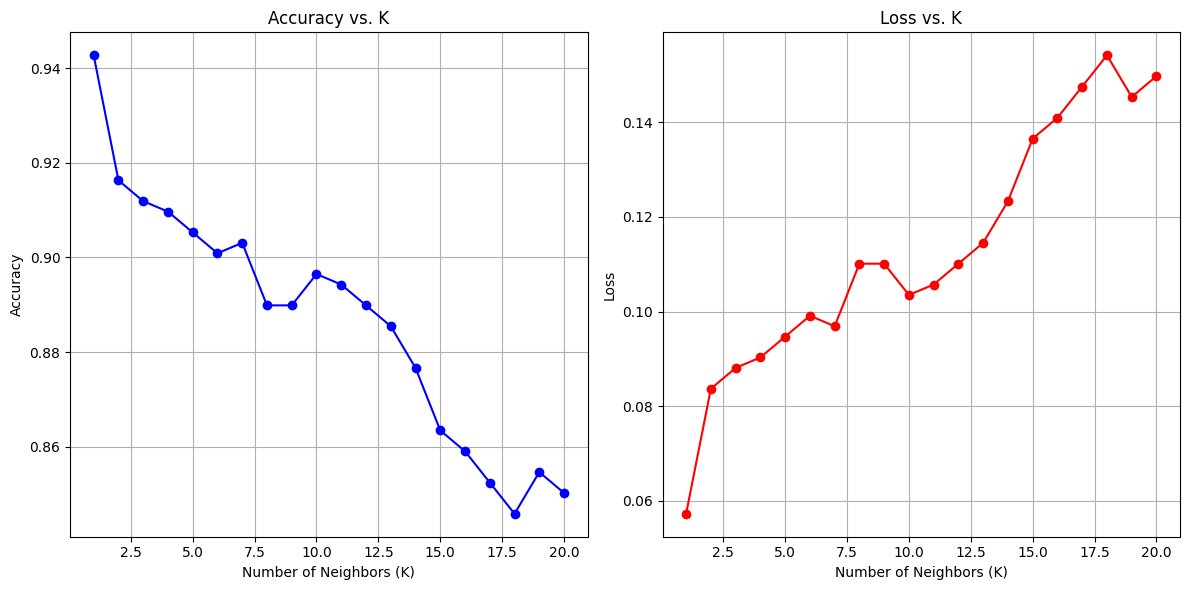

In [ ]:

# Danh sách các giá trị của k để thử nghiệm
k_values = range(1, 21)
accuracies = []
losses = []

for k in k_values:
    # Khởi tạo và huấn luyện mô hình KNN với giá trị k hiện tại
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(pca_train_data, y_train.argmax(axis=1))

    # Dự đoán và tính độ chính xác
    knn_predictions = knn_model.predict(pca_test_data)
    accuracy = accuracy_score(y_test.argmax(axis=1), knn_predictions)
    loss = 1 - accuracy  # Mất mát = 1 - độ chính xác

    # Lưu kết quả vào danh sách
    accuracies.append(accuracy)
    losses.append(loss)

# Vẽ biểu đồ Accuracy và Loss
plt.figure(figsize=(12, 6))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o', color='b')
plt.title("Accuracy vs. K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.grid(True)

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(k_values, losses, marker='o', color='r')
plt.title("Loss vs. K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

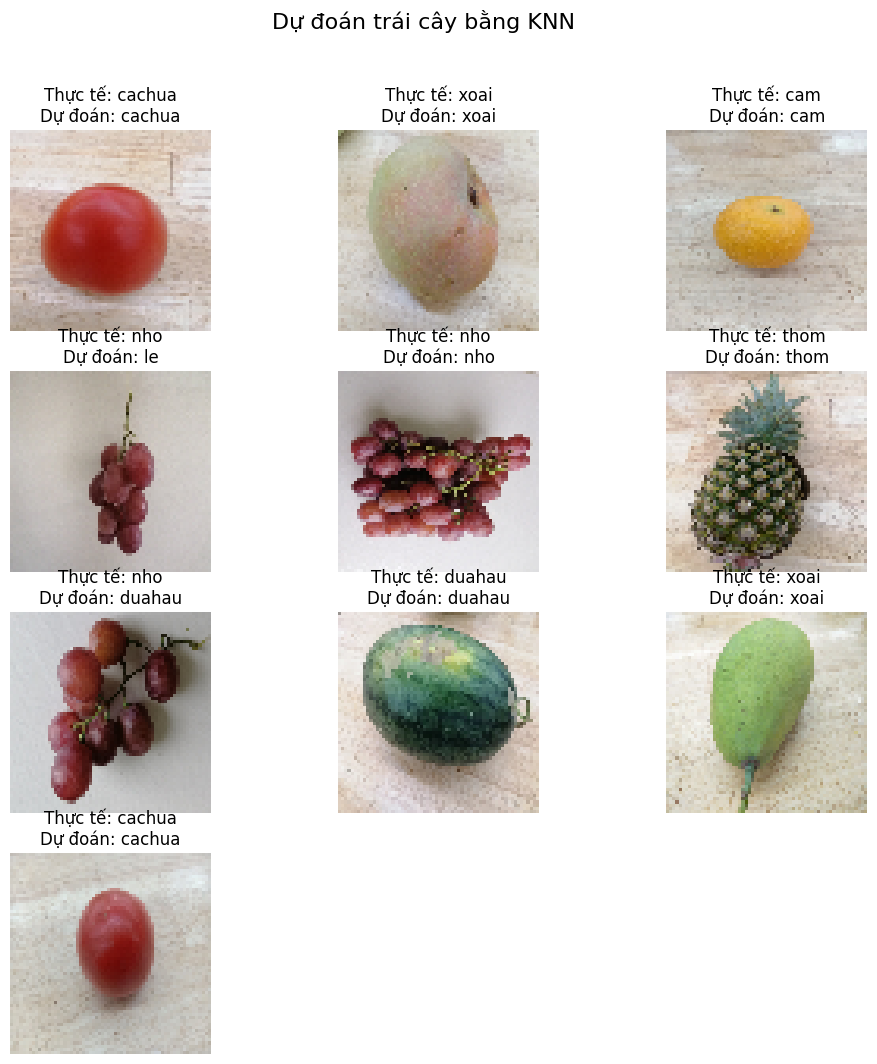

In [ ]:
# Chọn ngẫu nhiên 9 ảnh từ tập kiểm tra để hiển thị
num_images = 10
indices = np.random.choice(range(len(X_test)), num_images, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # Dự đoán nhãn cho ảnh đã chọn
    image = X_test[idx]
    true_label = categories[y_test[idx].argmax()]  # Nhãn thực tế
    pca_image = pca.transform(image.reshape(1, -1))  # Áp dụng PCA lên ảnh
    pred_label = categories[knn_model.predict(pca_image)[0]]  # Nhãn dự đoán

    # Hiển thị ảnh
    plt.subplot(4, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Thực tế: {true_label}\nDự đoán: {pred_label}")
    plt.axis('off')

plt.suptitle("Dự đoán trái cây bằng KNN", fontsize=16)
plt.show()


Processing: cachua_10.jpg of cachua


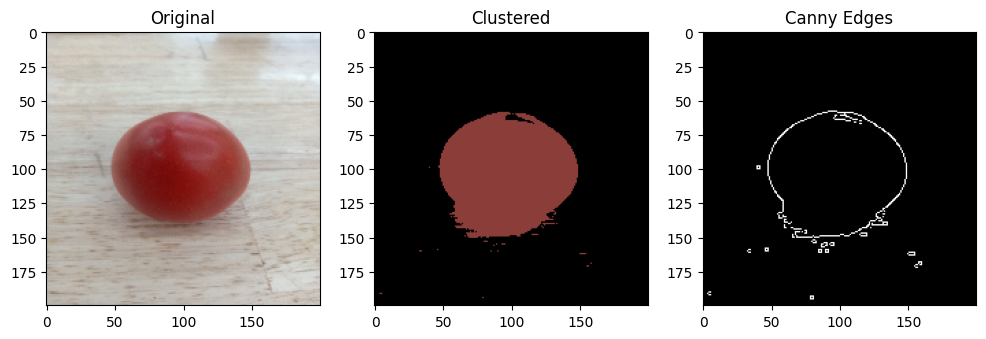

Processing: cam_1.jpg of cam


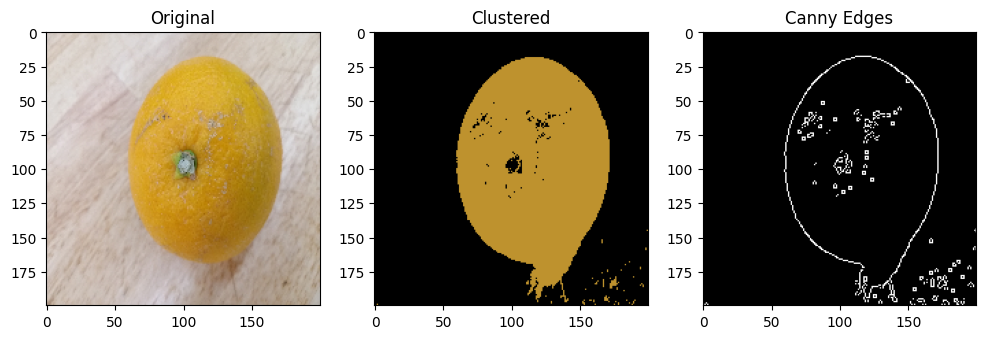

Processing: bananas.jpg of chuoi


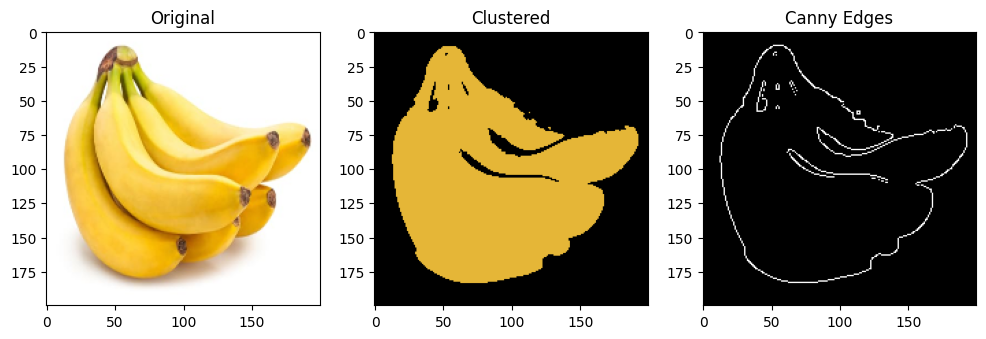

Processing: duahau_0.jpg of duahau


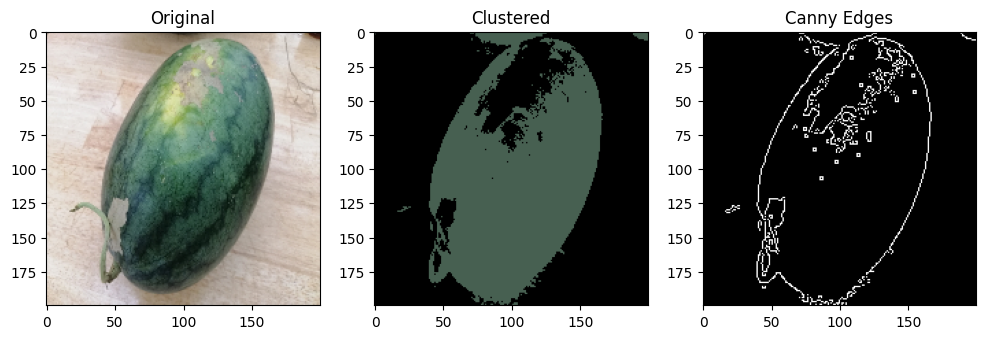

Processing: le_1.jpg of le


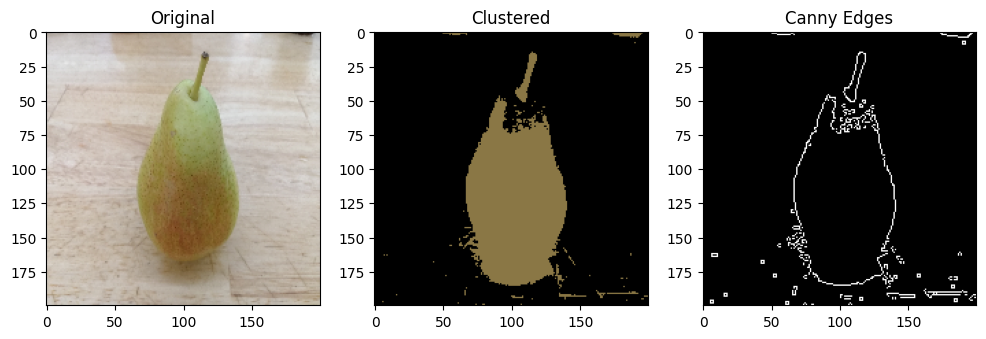

Processing: nho_100.jpg of nho


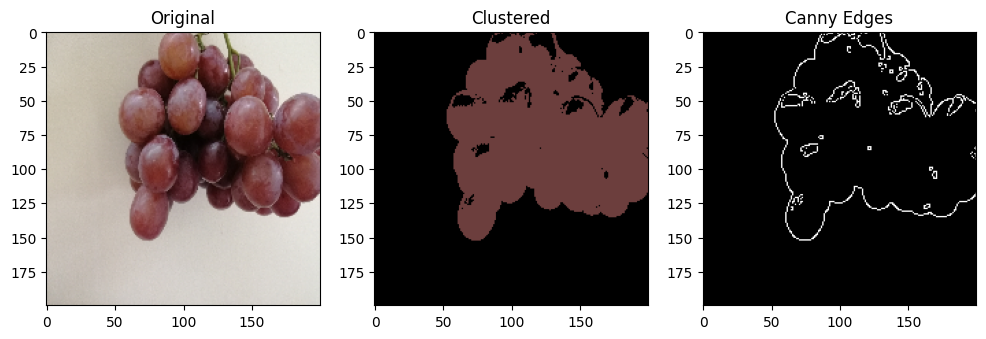

Processing: quyt_0.jpg of quyt


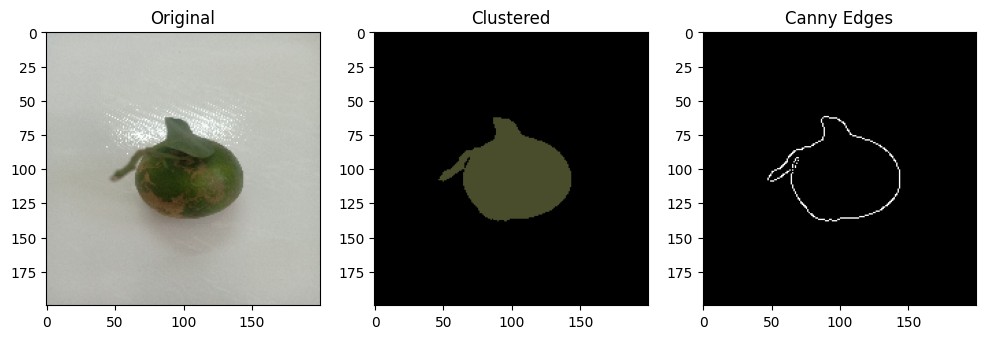

Processing: tao_102.jpg of tao


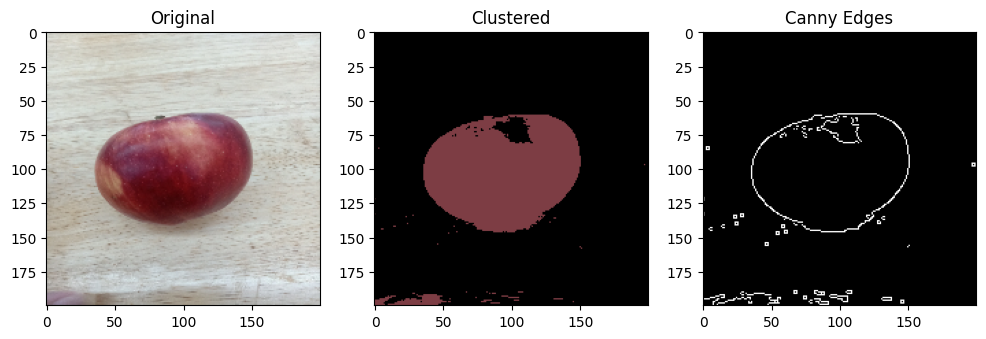

Processing: thom_102.jpg of thom


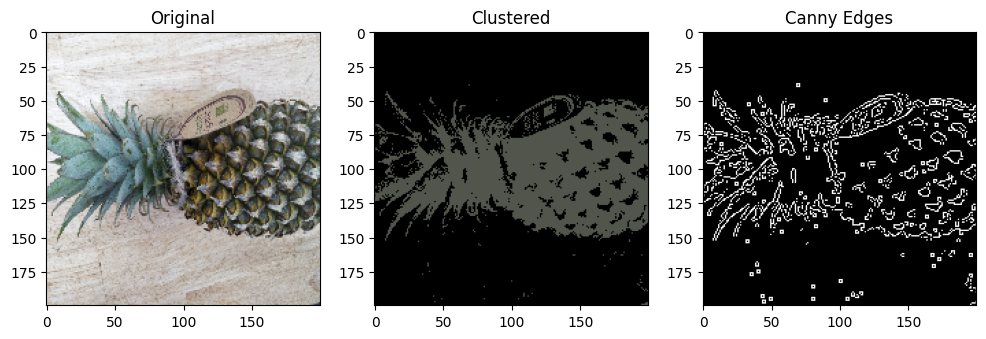

Processing: xoai_0.jpg of xoai


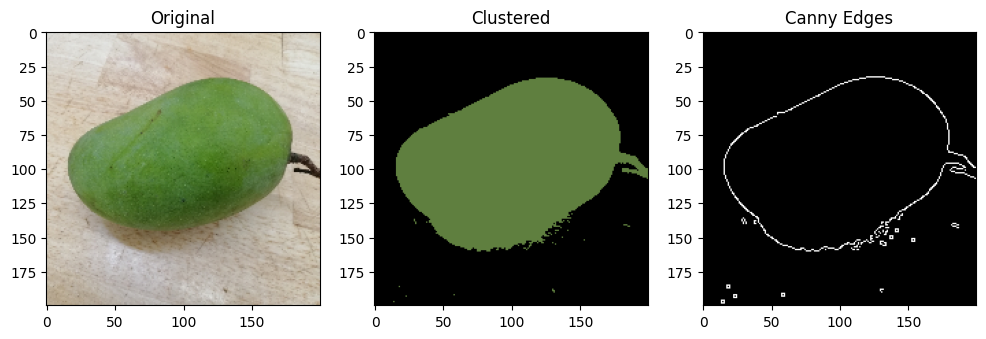

In [ ]:

def clustering_image(img):
    vectorized = img.reshape((-1, 3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 10
    ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    return result_image, center

def remove_light_color(img, center_color):
    light_color = max(sum(center_color[0]), sum(center_color[1]))
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if sum(img[x][y]) == light_color:
                img[x][y][0] = 0
                img[x][y][1] = 0
                img[x][y][2] = 0
    return img

def Canny_Detect(img):
    edge = cv2.Canny(img, 70, 50)
    return edge

f_name = ['cachua', 'cam', 'chuoi', 'duahau', 'le', 'nho', 'quyt', 'tao', 'thom', 'xoai']

for name in f_name:
    image_path = os.path.join("/content/drive/MyDrive/TraiCay", name)
    processed_first_image = False  # Cờ kiểm tra đã xử lý hình ảnh đầu tiên

    for filename in os.listdir(image_path):
        if filename.endswith(".jpg"):
            full_path = os.path.join(image_path, filename)

            if not processed_first_image:  # Xử lý chỉ hình ảnh đầu tiên
                img = cv2.imread(full_path)
                if img is not None:  # Check if image loaded successfully
                    print(f"Processing: {filename} of {name}")

                    resized = cv2.resize(img, (200, 200))
                    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

                    image, center = clustering_image(resized)
                    image = remove_light_color(image, center)
                    edge = Canny_Detect(image)

                    # Display images (optional)
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 3, 1)
                    plt.imshow(resized)
                    plt.title("Original")

                    plt.subplot(1, 3, 2)
                    plt.imshow(image)
                    plt.title("Clustered")

                    plt.subplot(1, 3, 3)
                    plt.imshow(edge, cmap='gray')
                    plt.title("Canny Edges")

                    plt.show()

                    processed_first_image = True  # Đánh dấu đã xử lý hình ảnh đầu tiên
                else:
                    print(f"Error: Could not read image file at {full_path}")


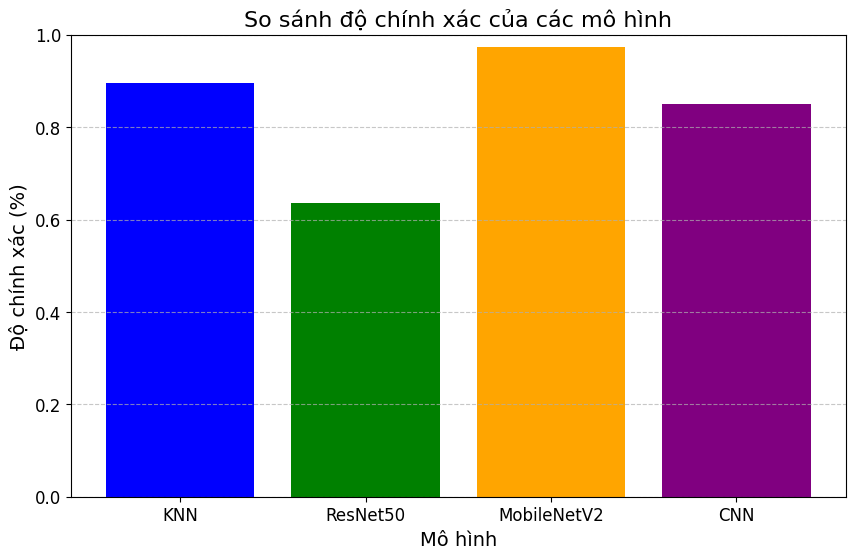

In [ ]:



# Tên các mô hình
models = ['KNN', 'ResNet50', 'MobileNetV2', 'CNN']
accuracies = [test_acc, test_acc_resnet, test_acc_mobilenet, accuracy]

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
plt.title('So sánh độ chính xác của các mô hình', fontsize=16)
plt.xlabel('Mô hình', fontsize=14)
plt.ylabel('Độ chính xác (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


